In [120]:
from sklearn.feature_selection import RFECV
from sklearn.model_selection import train_test_split
import numpy as np
import pandas as pd

In [121]:
# Load dataset
df = pd.read_csv('../dataset/attendance.csv')

In [122]:
# Label Encoding
from sklearn.preprocessing import LabelEncoder

labelencoder = LabelEncoder()
df['y'] = labelencoder.fit_transform(df['result'])

In [123]:
X = df['command'].values
y = df['y'].values

In [124]:
# Create features
from sklearn.feature_extraction.text import TfidfVectorizer
tfidf = TfidfVectorizer(
    sublinear_tf=True, 
    min_df=3, norm='l2', 
    encoding='latin-1', 
    ngram_range=(1, 2))

In [125]:
# split into train test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [126]:
# Model
from sklearn.svm import LinearSVC
from xgboost import XGBClassifier
#model = LinearSVC()
model = XGBClassifier(objective="multiclass", eval_metric="mlogloss", random_state=42, use_label_encoder=False)


In [127]:
from sklearn.pipeline import Pipeline

In [128]:
pipeline = Pipeline([('tfidf', tfidf), ('classifier', model)])

In [129]:
pipeline.fit(X_train, y_train)

Pipeline(steps=[('tfidf',
                 TfidfVectorizer(encoding='latin-1', min_df=3,
                                 ngram_range=(1, 2), sublinear_tf=True)),
                ('classifier',
                 XGBClassifier(base_score=0.5, booster='gbtree',
                               colsample_bylevel=1, colsample_bynode=1,
                               colsample_bytree=1, enable_categorical=False,
                               eval_metric='mlogloss', gamma=0, gpu_id=-1,
                               importance_type=None, interaction_constraints='',
                               learning_rate=0.300000012, max_delta_step=0,
                               max_depth=6, min_child_weight=1, missing=nan,
                               monotone_constraints='()', n_estimators=100,
                               n_jobs=8, num_parallel_tree=1,
                               objective='multi:softprob', predictor='auto',
                               random_state=42, reg_alpha=0, reg_lam

In [130]:
pipeline.score(X_test, y_test)

0.7692307692307693

In [131]:
pipeline.predict_proba(["time in po muna"])

array([[0.04223435, 0.01389132, 0.9358522 , 0.00459011, 0.00343203]],
      dtype=float32)

In [132]:
labelencoder.classes_

array(['BREAK', 'RESUME', 'TIMEIN', 'TIMEOUT', 'UNKNOWN'], dtype=object)

In [133]:
def classify(command):
    classes = labelencoder.classes_
    prediction = pipeline.predict_proba([command])[0]
    predicted_class = np.where(prediction == np.amax(prediction))
    idx = predicted_class[0][0]
    return classes[idx], prediction[idx]


In [134]:
classify("time out po muna")
#classify("break po muna ako. balik ako later")
#classify("papasok po si cassy")
#classify("time out po muna ako ngayon")

('BREAK', 0.9545426)

# Save Model

In [135]:
# Save Model using pickle
import pickle
filename = '../models/attendance_classifier.pickle'
classifier = {
    "model": pipeline,
    "classes": labelencoder.classes_
}
pickle.dump(classifier, open(filename, 'wb'))

In [136]:
# Load Model using pickle
loaded_classifier = pickle.load(open(filename, 'rb'))
loaded_classifier["model"].score(X_test, y_test)

0.7692307692307693

In [137]:
# Metrics
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

y_hat = pipeline.predict(X_test)

def plot_confusion_matrix(model):
    cm = confusion_matrix(y_test, y_hat, labels=model.classes_)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labelencoder.classes_)
    disp.plot()
    plt.show()

In [138]:
# display failed predictions
for text, prediction, truth in zip(X_test, y_hat, y_test):
    if(prediction == truth):
        continue
    print(text, labelencoder.classes_[prediction], labelencoder.classes_[truth])

time for now RESUME UNKNOWN
time in again TIMEIN RESUME
timeout muna TIMEOUT BREAK


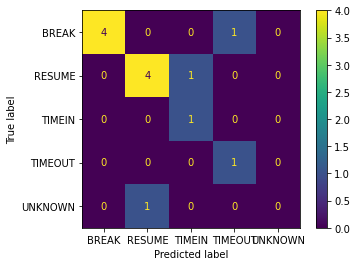

In [139]:
plot_confusion_matrix(pipeline)

In [140]:
classify("tilein uoit")

('RESUME', 0.50138825)

In [141]:
classify("time out po muna ako hehe")

('BREAK', 0.9545426)

In [151]:
classify("break po muna. balik ako maya maya")

('BREAK', 0.9723829)

In [155]:
classify("I'd like to time in")

('TIMEIN', 0.8329646)